In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from wordcloud import WordCloud
import seaborn as sns

In [ ]:
df = pd.read_csv('abcnews-date-text.csv')
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')
df['year'] = df['publish_date'].dt.year

In [ ]:
# Load the tokenizer and model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Batch processing function
def process_batches(texts, batch_size=32):
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        yield torch.nn.functional.softmax(outputs.logits, dim=-1)

In [ ]:
# Calculate sentiments
all_sentiments = []
for batch_predictions in tqdm(process_batches(df['headline_text'].tolist()), total=len(df) // 32 + 1):
    all_sentiments.extend(batch_predictions[:, 1].tolist())  # Positive sentiment scores

df['sentiment'] = all_sentiments

100%|██████████| 36278/36278 [09:10<00:00, 65.89it/s]


In [ ]:
# Aggregate sentiment by year
sentiment_by_year = df.groupby('year').agg({
    'sentiment': 'sum',
    'headline_text': 'count'
}).rename(columns={'sentiment': 'positive_score', 'headline_text': 'headline_count'})

sentiment_by_year['negative_score'] = sentiment_by_year['headline_count'] - sentiment_by_year['positive_score']
sentiment_by_year['positive_ratio'] = sentiment_by_year['positive_score'] / sentiment_by_year['headline_count']

In [ ]:
# Save to CSV
sentiment_by_year.to_csv('sentiment_by_year.csv', index=True)

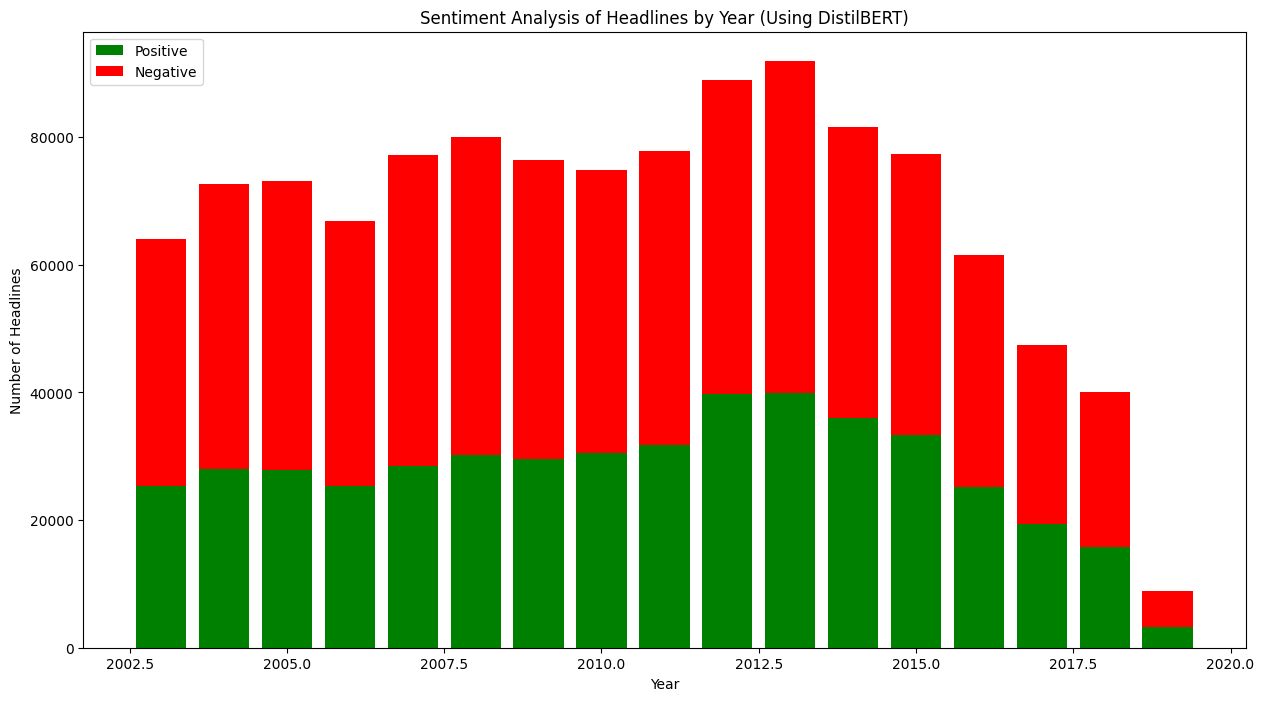

In [ ]:
# Plot 1: Positive and Negative Headline Counts
plt.figure(figsize=(15, 8))
bars = plt.bar(sentiment_by_year.index, sentiment_by_year['positive_score'], label='Positive', color='green')
bars_neg = plt.bar(sentiment_by_year.index, sentiment_by_year['negative_score'],
                   bottom=sentiment_by_year['positive_score'], label='Negative', color='red')

plt.xlabel('Year')
plt.ylabel('Number of Headlines')
plt.title('Sentiment Analysis of Headlines by Year (Using DistilBERT)')
plt.legend(loc='upper left')

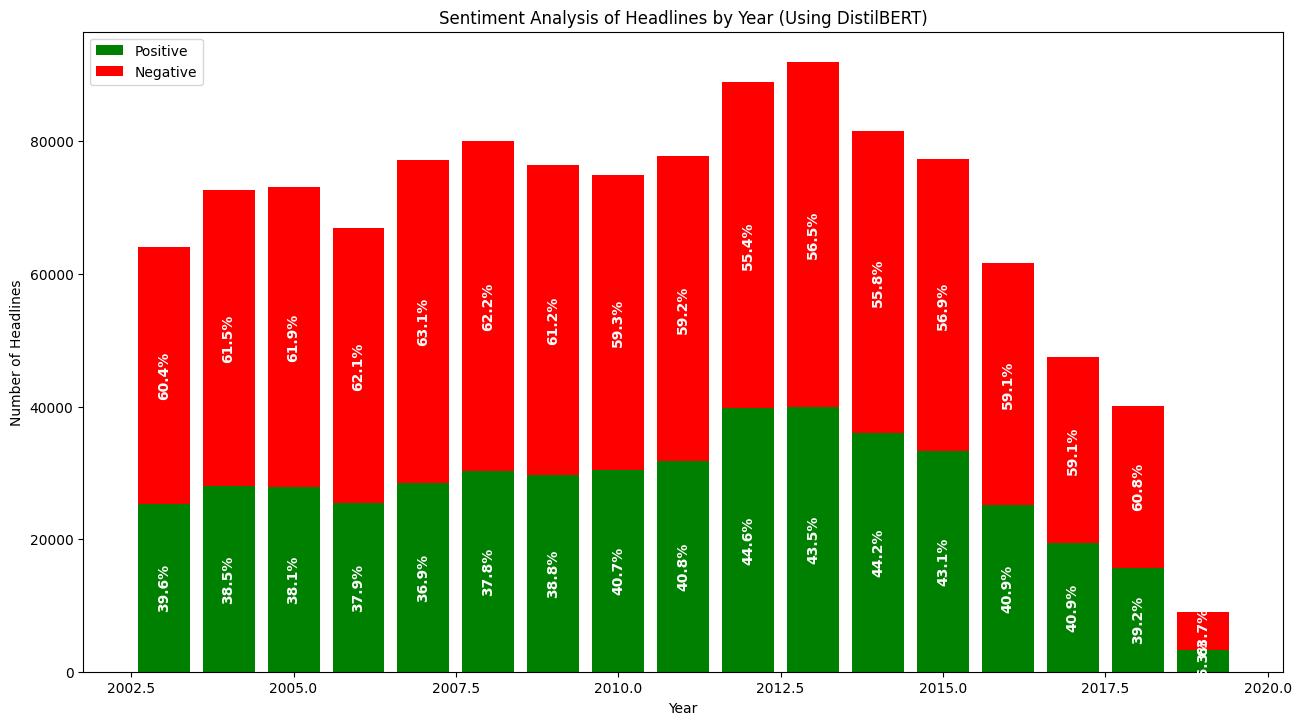

In [ ]:
# Add percentages to the bars
def add_percentages(bars, bars_neg):
    for bar, bar_neg in zip(bars, bars_neg):
        total = bar.get_height() + bar_neg.get_height()
        if total > 0:  # Avoid division by zero
            positive_percentage = (bar.get_height() / total) * 100
            negative_percentage = (bar_neg.get_height() / total) * 100

            # Add positive percentage to positive bar
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() / 2,
                f'{positive_percentage:.1f}%',
                ha='center',
                va='center',
                rotation=90,
                color='white',
                fontweight='bold'
            )

            # Add negative percentage to negative bar
            plt.text(
                bar_neg.get_x() + bar_neg.get_width() / 2,
                bar.get_height() + bar_neg.get_height() / 2,
                f'{negative_percentage:.1f}%',
                ha='center',
                va='center',
                rotation=90,
                color='white',
                fontweight='bold'
            )

# Set the figure size explicitly
plt.figure(figsize=(15, 8))

# Plot the bars
bars = plt.bar(sentiment_by_year.index, sentiment_by_year['positive_score'], label='Positive', color='green')
bars_neg = plt.bar(
    sentiment_by_year.index,
    sentiment_by_year['negative_score'],
    bottom=sentiment_by_year['positive_score'],
    label='Negative',
    color='red'
)

# Add percentages
add_percentages(bars, bars_neg)

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Number of Headlines')
plt.title('Sentiment Analysis of Headlines by Year (Using DistilBERT)')
plt.legend(loc='upper left')

# Adjust layout to prevent overlaps
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Display the plot
plt.show()

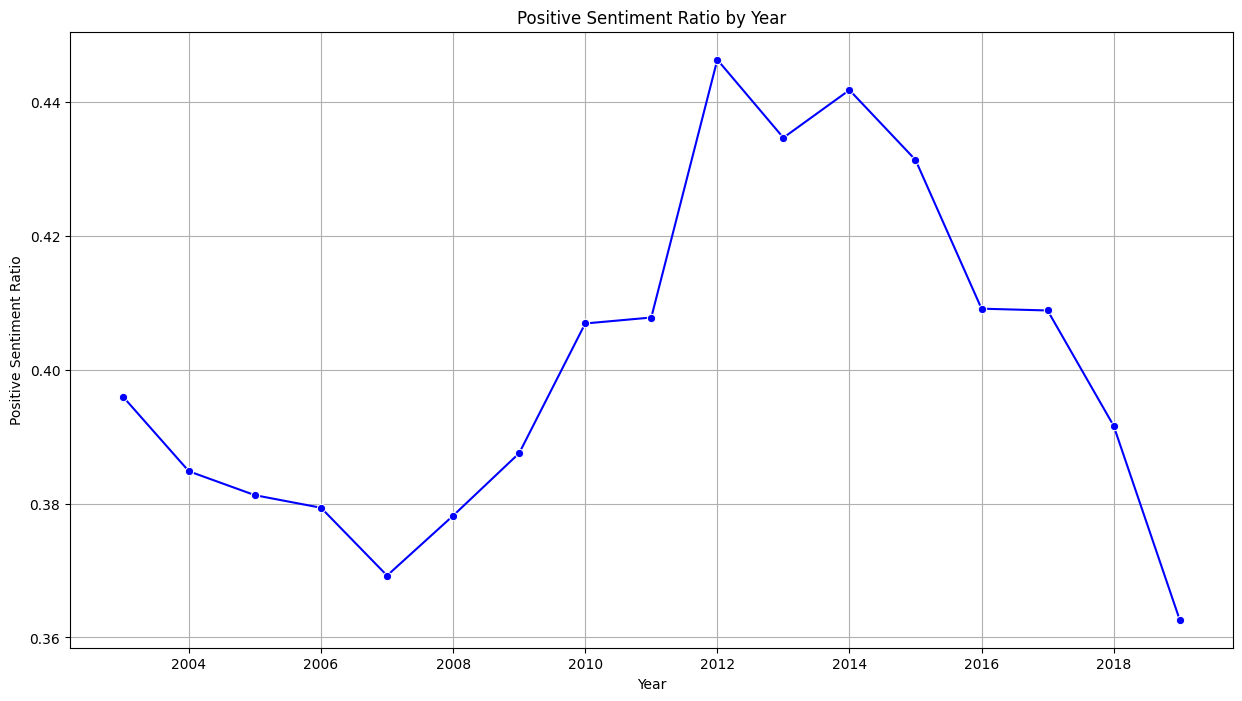

In [ ]:
# Plot 2: Positive Sentiment Ratio Over Time
plt.figure(figsize=(15, 8))
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year['positive_ratio'], marker='o', color='blue')
plt.title('Positive Sentiment Ratio by Year')
plt.xlabel('Year')
plt.ylabel('Positive Sentiment Ratio')
plt.grid(True)
plt.show()

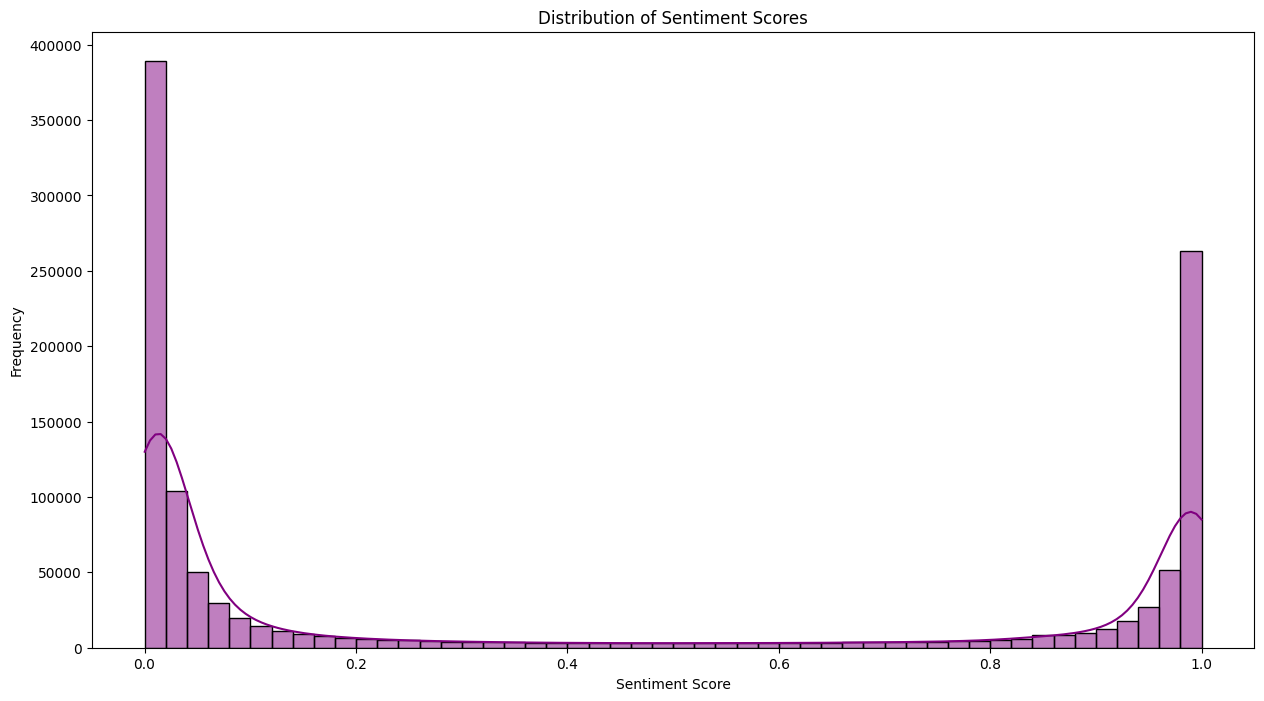

In [ ]:
# Plot 3: Sentiment Score Distribution
plt.figure(figsize=(15, 8))
sns.histplot(df['sentiment'], bins=50, kde=True, color='purple')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Word Clouds for Positive and Negative Headlines
for year in sentiment_by_year.index:
    yearly_data = df[df['year'] == year]
    positive_texts = " ".join(yearly_data[yearly_data['sentiment'] > 0.5]['headline_text'].tolist())
    negative_texts = " ".join(yearly_data[yearly_data['sentiment'] <= 0.5]['headline_text'].tolist())

    wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
    wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_texts)

    # Positive Word Cloud
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.title(f'Positive Headlines Word Cloud ({year})')
    plt.axis('off')
    plt.show()

    # Negative Word Cloud
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.title(f'Negative Headlines Word Cloud ({year})')
    plt.axis('off')
    plt.show()

# Highlight Most Positive and Negative Headlines
top_positive = df.nlargest(10, 'sentiment')[['headline_text', 'sentiment']]
top_negative = df.nsmallest(10, 'sentiment')[['headline_text', 'sentiment']]

print("Top 10 Positive Headlines:")
print(top_positive)

print("\nTop 10 Negative Headlines:")
print(top_negative)